In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.transforms import ToTensor
import tensorflow as tf

from torch.autograd import Variable
import torch.nn as nn

from tensorflow import keras 

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, regularizers, layers
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, KFold, train_test_split,StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix

In [ ]:
#pip install torch
#pip install torch.nn 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
#calculate confidence interval
def get_standard_diviation(values):
  mean = np.mean(values)
  n = len(values)
  s = np.sqrt(np.sum((values-mean)**2)/(n-1))

  return s

# Multiple visit data set

In [ ]:
df_mult= pd.read_csv("/content/gdrive/My Drive/Speciale/clindata_multiple_visits.csv", sep=",", header=0)
df_mult = df_mult.set_index("iD")
df_mult= df_mult.drop(["Unnamed: 0"],axis=1)

# Get data

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/Speciale/clindata_new_25042022", sep=",", header=0)
df = df.set_index("iD")
df= df.drop(["Unnamed: 0"],axis=1)

y = df["y"]

#### Seperate data in train and test

In [ ]:
TRAIN = pd.read_csv("/content/gdrive/My Drive/Speciale/matched_15032022", sep=",", header=0)
TRAIN = TRAIN.set_index("Unnamed: 0")
TRAIN = TRAIN.index

VAL = pd.read_csv("/content/gdrive/My Drive/Speciale/validation_15032022", sep=",", header=0)
VAL = VAL.set_index("Unnamed: 0")
VAL = VAL.index

In [ ]:
print("All: ", df.shape )

df["id"] = [int(i[:7]) for i in df.index]

# Select validation or training mode VAL or TRAIN
train = df.loc[ df['id'].isin(TRAIN)]
val = df.loc[~df['id'].isin(TRAIN)]

train = train.drop(["id"],axis=1)
val = val.drop(["id"],axis=1)

print("Train", train.shape)
print("Val", val.shape)
train.shape[0]+val.shape[0]

y = train["y"]
train= train.drop(["y"],axis=1)

y_val = val["y"]
val= val.drop(["y"],axis=1)

All:  (1506, 39)
Train (1232, 39)
Val (274, 39)


In [ ]:
#mult visits
print("All: ", df_mult.shape )

df_mult["id"] = [int(i[:7]) for i in df_mult.index]

# Select validation or training mode VAL or TRAIN
train_mult = df_mult.loc[ df_mult['id'].isin(TRAIN)]
val_mult = df_mult.loc[~df_mult['id'].isin(TRAIN)]

train_mult = train_mult.drop(["id"],axis=1)
val_mult = val_mult.drop(["id"],axis=1)

print("Train_mult", train_mult.shape)
print("Val_mult", val_mult.shape)
train_mult.shape[0]+val_mult.shape[0]

y_mult = train_mult["y"]
train_mult= train_mult.drop(["y"],axis=1)

y_mult_val = val_mult["y"]
val_mult= val_mult.drop(["y"],axis=1)

All:  (1114, 64)
Train_mult (894, 64)
Val_mult (220, 64)


## Split in visits

In [ ]:
k = 8
n = 10

constants = train.iloc[:, :k]
# split into vitsits
v00 = (train.iloc[:,k:n+k])
v00 = pd.concat([constants, v00], axis=1)

v01 = (train.iloc[:,k+n:2*n+k])
v01 = pd.concat([constants, v01], axis=1)

v03 = (train.iloc[:, 2*n+k:])
v03 = pd.concat([constants, v03], axis=1)


#ALSO FOR VALIDAtION
constants_val = val.iloc[:, :k]
# split into vitsits
v00_val = (val.iloc[:,k:n+k])
v00_val = pd.concat([constants_val, v00_val], axis=1)

v01_val = (val.iloc[:,k+n:2*n+k])
v01_val = pd.concat([constants_val, v01_val], axis=1)

v03_val = (val.iloc[:, 2*n+k:])
v03_val = pd.concat([constants_val, v03_val], axis=1)

In [ ]:
v00.shape, v01.shape, v03.shape, v00_val.shape, v01_val.shape, v03_val.shape,

((1232, 18), (1232, 18), (1232, 18), (274, 18), (274, 18), (274, 18))

In [ ]:
k = 8
n = int((64-k-1)/5)

constants_mult = train_mult.iloc[:, :k]
# split into vitsits
v00_mult = (train_mult.iloc[:,k:n+k])
v00_mult = pd.concat([constants_mult, v00_mult], axis=1)

v01_mult = (train_mult.iloc[:,k+n:2*n+k])
v01_mult = pd.concat([constants_mult, v01_mult], axis=1)

v03_mult = (train_mult.iloc[:, 2*n+k:3*n+k])
v03_mult = pd.concat([constants_mult, v03_mult], axis=1)

v04_mult = (train_mult.iloc[:, 3*n+k:4*n+k])
v04_mult = pd.concat([constants_mult, v04_mult], axis=1)

v05_mult = (train_mult.iloc[:, 4*n+k:5*n+k])
v05_mult = pd.concat([constants_mult, v05_mult], axis=1)


#Validation
constants_mult_val = val_mult.iloc[:, :k]
# split into vitsits
v00_mult_val = (val_mult.iloc[:,k:n+k])
v00_mult_val = pd.concat([constants_mult_val, v00_mult_val], axis=1)

v01_mult_val = (val_mult.iloc[:,k+n:2*n+k])
v01_mult_val = pd.concat([constants_mult_val, v01_mult_val], axis=1)

v03_mult_val = (val_mult.iloc[:, 2*n+k:3*n+k])
v03_mult_val = pd.concat([constants_mult_val, v03_mult_val], axis=1)

v04_mult_val = (val_mult.iloc[:, 3*n+k:4*n+k])
v04_mult_val = pd.concat([constants_mult_val, v04_mult_val], axis=1)

v05_mult_val = (val_mult.iloc[:, 4*n+k:5*n+k])
v05_mult_val = pd.concat([constants_mult_val, v05_mult_val], axis=1)

In [ ]:
v00_mult.shape, v01_mult.shape, v03_mult.shape, v04_mult.shape, v05_mult.shape, v00_mult_val.shape, v01_mult_val.shape, v03_mult_val.shape, v04_mult_val.shape, v05_mult_val.shape

((894, 19),
 (894, 19),
 (894, 19),
 (894, 19),
 (894, 19),
 (220, 19),
 (220, 19),
 (220, 19),
 (220, 19),
 (220, 19))

In [ ]:
#Combine 
df_all = np.array([v00,v01,v03])
df_all = np.moveaxis(df_all, 0, 1)

# and validation
df_all_val = np.array([v00_val,v01_val,v03_val])
df_all_val = np.moveaxis(df_all_val, 0, 1)

df_all.shape, y.shape, df_all_val.shape, y_val.shape

((1232, 3, 18), (1232,), (274, 3, 18), (274,))

In [ ]:
#Combine 
df_all_mult = np.array([v00_mult,v01_mult,v03_mult,v04_mult,v05_mult])
df_all_mult = np.moveaxis(df_all_mult, 0, 1)

# Validation
df_all_mult_val = np.array([v00_mult_val,v01_mult_val,v03_mult_val,v04_mult_val,v05_mult_val])
df_all_mult_val = np.moveaxis(df_all_mult_val, 0, 1)

df_all_mult.shape, y_mult.shape, df_all_mult_val.shape, y_mult_val.shape

((894, 5, 19), (894,), (220, 5, 19), (220,))

In [ ]:
# Make data with 3 visits from multiple set
df_all_5v3 = df_all_mult[:,:3,:]

# Baseline model

In [ ]:
dropout_rate = 0.1# 0.2 #from grid
learning_rate = 0.001 #0.001 #from grid
recurrent_rate = 0.#0.2


# make stratified KFOLD 
n_split=10

skf = StratifiedKFold(n_splits=n_split, shuffle=False)
mean = 0
accuracy = []


for train_index, test_index in skf.split(df_all, y):
    Xtrain = df_all[train_index]
    ytrain = y[train_index]
    Xtest = df_all[test_index]
    ytest = y[test_index]

    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

    model = Sequential()
    x= layers.BatchNormalization(axis=-1,
                                 momentum=0.99,
                                 epsilon=0.0001)(inputs)

    x = layers.LSTM(10, #Bidirectional
                    activation ="tanh",
                    recurrent_activation = "sigmoid",
                    return_sequences=True, 
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2]))(x)
    
    x = layers.LSTM(7, 
                    activation ="tanh",
                    recurrent_activation = "sigmoid",
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    return_sequences=False)(x)

    x = layers.Dense(15,activation = "softmax")(x)#softmax
    #x = layers.Dropout(dropout_rate) (x)

    x = layers.Dense(5, activation = "sigmoid")(x)
    #x = layers.Dropout(dropout_rate) (x)

    outputs = layers.Dense(1, activation = "sigmoid")(x)  

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
        #loss=tf.keras.losses.KLDivergence(reduction="auto", name="kl_divergence"),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )
    
    history = model.fit(Xtrain, ytrain, epochs=1000, validation_split=0.20, verbose=1)#, callbacks=EarlyStopping(monitor='val_loss', patience=25), batch_size=25) #batch_size=75,monitor='val_loss'

    train_scores = model.evaluate(Xtrain, ytrain, verbose=2)
    test_scores = model.evaluate(Xtest, ytest, verbose=2)
    print("Train loss:", train_scores[0])
    print("Train accuracy:", train_scores[1])
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    accuracy.append(test_scores[1])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train","Test"],loc="best")
    plt.show()

print("Mean acc: ", np.mean(accuracy))
#create 95% confidence interval for population mean weight
print("Confidence interval: ", get_standard_diviation(accuracy) )
print("All: ", accuracy )

Epoch 1/1000
28/28 [==============================] - 10s 42ms/step - loss: 0.2600 - auc: 0.5572 - val_loss: 0.2497 - val_auc: 0.5000
Epoch 2/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.2386 - auc: 0.5312 - val_loss: 0.2450 - val_auc: 0.5482
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.2193 - auc: 0.5763 - val_loss: 0.2420 - val_auc: 0.7278
Epoch 4/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.2025 - auc: 0.6028 - val_loss: 0.2404 - val_auc: 0.7520
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.1885 - auc: 0.6593 - val_loss: 0.2406 - val_auc: 0.7594
Epoch 6/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.1776 - auc: 0.6957 - val_loss: 0.2422 - val_auc: 0.7671
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.1693 - auc: 0.7281 - val_loss: 0.2444 - val_auc: 0.7534
Epoch 8/1000
28/28 [==============================] - 0s 9ms/step - loss

KeyboardInterrupt: ignored

In [ ]:
accuracy

# Image model 

Epoch 1/1000
36/36 [==============================] - 12s 91ms/step - loss: 0.6990 - auc: 0.5822 - val_loss: 0.9815 - val_auc: 0.8067
Epoch 2/1000
36/36 [==============================] - 2s 56ms/step - loss: 0.6430 - auc: 0.6114 - val_loss: 0.7361 - val_auc: 0.8110
Epoch 3/1000
36/36 [==============================] - 2s 61ms/step - loss: 0.6141 - auc: 0.6213 - val_loss: 0.7847 - val_auc: 0.8031
Epoch 4/1000
36/36 [==============================] - 2s 57ms/step - loss: 0.5852 - auc: 0.6857 - val_loss: 0.7764 - val_auc: 0.8068
Epoch 5/1000
36/36 [==============================] - 2s 61ms/step - loss: 0.5704 - auc: 0.6440 - val_loss: 0.7092 - val_auc: 0.8094
Epoch 6/1000
36/36 [==============================] - 2s 58ms/step - loss: 0.5397 - auc: 0.7102 - val_loss: 0.8801 - val_auc: 0.8057
Epoch 7/1000
36/36 [==============================] - 2s 60ms/step - loss: 0.5355 - auc: 0.6988 - val_loss: 0.7161 - val_auc: 0.7947
Epoch 8/1000
36/36 [==============================] - 2s 59ms/step -

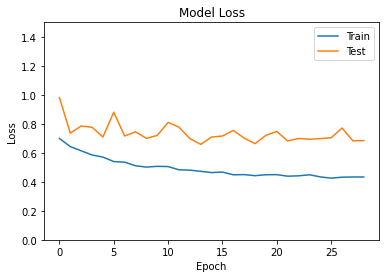

Epoch 1/1000
36/36 [==============================] - 11s 89ms/step - loss: 0.7565 - auc: 0.4908 - val_loss: 1.0109 - val_auc: 0.7628
Epoch 2/1000
36/36 [==============================] - 2s 61ms/step - loss: 0.6931 - auc: 0.4966 - val_loss: 0.9926 - val_auc: 0.8094
Epoch 3/1000
36/36 [==============================] - 2s 58ms/step - loss: 0.6256 - auc: 0.5777 - val_loss: 0.8674 - val_auc: 0.8009
Epoch 4/1000
36/36 [==============================] - 2s 61ms/step - loss: 0.5775 - auc: 0.6624 - val_loss: 0.7931 - val_auc: 0.8033
Epoch 5/1000
36/36 [==============================] - 2s 57ms/step - loss: 0.5359 - auc: 0.7115 - val_loss: 0.7552 - val_auc: 0.7986
Epoch 6/1000
36/36 [==============================] - 2s 64ms/step - loss: 0.5335 - auc: 0.7135 - val_loss: 0.7227 - val_auc: 0.8089
Epoch 7/1000
36/36 [==============================] - 2s 60ms/step - loss: 0.5208 - auc: 0.7051 - val_loss: 0.7902 - val_auc: 0.8042
Epoch 8/1000
36/36 [==============================] - 2s 59ms/step -

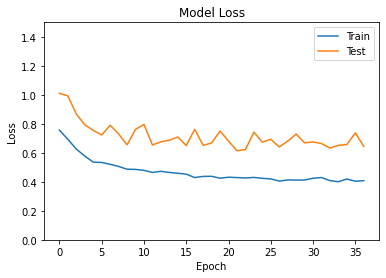

Epoch 1/1000
36/36 [==============================] - 12s 89ms/step - loss: 0.7309 - auc: 0.5370 - val_loss: 1.0662 - val_auc: 0.8027
Epoch 2/1000
36/36 [==============================] - 2s 62ms/step - loss: 0.6718 - auc: 0.5841 - val_loss: 0.9213 - val_auc: 0.8158
Epoch 3/1000
36/36 [==============================] - 2s 60ms/step - loss: 0.6177 - auc: 0.6460 - val_loss: 0.8221 - val_auc: 0.8152
Epoch 4/1000
36/36 [==============================] - 2s 60ms/step - loss: 0.5658 - auc: 0.7240 - val_loss: 0.7303 - val_auc: 0.8140
Epoch 5/1000
36/36 [==============================] - 2s 57ms/step - loss: 0.5437 - auc: 0.7433 - val_loss: 0.6864 - val_auc: 0.8060
Epoch 6/1000
36/36 [==============================] - 2s 63ms/step - loss: 0.5432 - auc: 0.7275 - val_loss: 0.7131 - val_auc: 0.8051
Epoch 7/1000
36/36 [==============================] - 2s 57ms/step - loss: 0.4984 - auc: 0.7779 - val_loss: 0.7553 - val_auc: 0.8045
Epoch 8/1000
36/36 [==============================] - 2s 62ms/step -

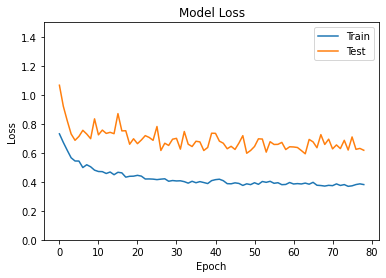

Epoch 1/1000
36/36 [==============================] - 12s 91ms/step - loss: 0.6987 - auc: 0.6072 - val_loss: 0.9273 - val_auc: 0.7974
Epoch 2/1000
36/36 [==============================] - 2s 58ms/step - loss: 0.6274 - auc: 0.6570 - val_loss: 0.8009 - val_auc: 0.8026
Epoch 3/1000
36/36 [==============================] - 2s 60ms/step - loss: 0.5925 - auc: 0.6934 - val_loss: 0.7388 - val_auc: 0.8033
Epoch 4/1000
36/36 [==============================] - 2s 63ms/step - loss: 0.5795 - auc: 0.6881 - val_loss: 0.7102 - val_auc: 0.8068
Epoch 5/1000
36/36 [==============================] - 2s 56ms/step - loss: 0.5375 - auc: 0.7455 - val_loss: 0.7090 - val_auc: 0.8061
Epoch 6/1000
36/36 [==============================] - 2s 65ms/step - loss: 0.5207 - auc: 0.7604 - val_loss: 0.7100 - val_auc: 0.8045
Epoch 7/1000
36/36 [==============================] - 2s 63ms/step - loss: 0.4937 - auc: 0.7829 - val_loss: 0.6948 - val_auc: 0.8009
Epoch 8/1000
36/36 [==============================] - 2s 63ms/step -

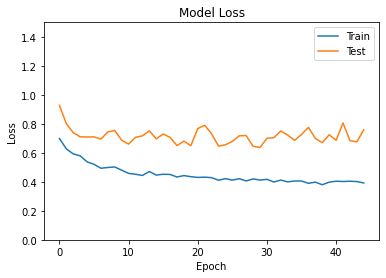

Epoch 1/1000
36/36 [==============================] - 13s 101ms/step - loss: 0.7216 - auc: 0.5201 - val_loss: 1.0157 - val_auc: 0.7781
Epoch 2/1000
36/36 [==============================] - 2s 68ms/step - loss: 0.6667 - auc: 0.5657 - val_loss: 0.9390 - val_auc: 0.7883
Epoch 3/1000
36/36 [==============================] - 2s 66ms/step - loss: 0.5966 - auc: 0.6974 - val_loss: 0.7582 - val_auc: 0.7845
Epoch 4/1000
36/36 [==============================] - 2s 67ms/step - loss: 0.5676 - auc: 0.7312 - val_loss: 0.8156 - val_auc: 0.7864
Epoch 5/1000
36/36 [==============================] - 2s 69ms/step - loss: 0.5443 - auc: 0.7441 - val_loss: 0.7079 - val_auc: 0.7844
Epoch 6/1000
36/36 [==============================] - 2s 66ms/step - loss: 0.4991 - auc: 0.7914 - val_loss: 0.7159 - val_auc: 0.7829
Epoch 7/1000
36/36 [==============================] - 3s 70ms/step - loss: 0.5249 - auc: 0.7336 - val_loss: 0.7177 - val_auc: 0.7830
Epoch 8/1000
36/36 [==============================] - 2s 67ms/step 

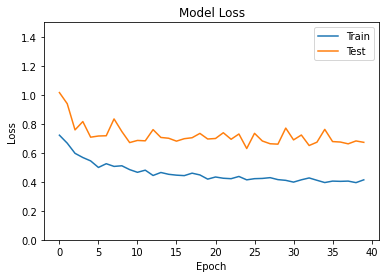

Epoch 1/1000
36/36 [==============================] - 12s 109ms/step - loss: 0.6907 - auc: 0.5413 - val_loss: 0.8892 - val_auc: 0.7980
Epoch 2/1000
36/36 [==============================] - 2s 62ms/step - loss: 0.6148 - auc: 0.6574 - val_loss: 0.8175 - val_auc: 0.7971
Epoch 3/1000
36/36 [==============================] - 2s 58ms/step - loss: 0.5695 - auc: 0.7174 - val_loss: 0.7626 - val_auc: 0.7955
Epoch 4/1000
36/36 [==============================] - 2s 61ms/step - loss: 0.5582 - auc: 0.6941 - val_loss: 0.7626 - val_auc: 0.7896
Epoch 5/1000
36/36 [==============================] - 2s 62ms/step - loss: 0.5429 - auc: 0.7127 - val_loss: 0.7748 - val_auc: 0.7912
Epoch 6/1000
36/36 [==============================] - 2s 63ms/step - loss: 0.5312 - auc: 0.7106 - val_loss: 0.7746 - val_auc: 0.7893
Epoch 7/1000
36/36 [==============================] - 2s 65ms/step - loss: 0.5067 - auc: 0.7397 - val_loss: 0.8041 - val_auc: 0.7819
Epoch 8/1000
36/36 [==============================] - 2s 61ms/step 

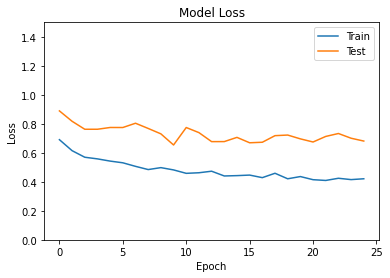

Epoch 1/1000
36/36 [==============================] - 12s 96ms/step - loss: 0.8003 - auc: 0.5134 - val_loss: 1.0060 - val_auc: 0.7564
Epoch 2/1000
36/36 [==============================] - 2s 60ms/step - loss: 0.6948 - auc: 0.5424 - val_loss: 0.9039 - val_auc: 0.8042
Epoch 3/1000
36/36 [==============================] - 2s 60ms/step - loss: 0.6581 - auc: 0.5517 - val_loss: 0.8218 - val_auc: 0.8128
Epoch 4/1000
36/36 [==============================] - 2s 63ms/step - loss: 0.5882 - auc: 0.6937 - val_loss: 0.7274 - val_auc: 0.8136
Epoch 5/1000
36/36 [==============================] - 2s 59ms/step - loss: 0.5720 - auc: 0.7108 - val_loss: 0.7191 - val_auc: 0.8137
Epoch 6/1000
36/36 [==============================] - 2s 64ms/step - loss: 0.5561 - auc: 0.7172 - val_loss: 0.6447 - val_auc: 0.8133
Epoch 7/1000
36/36 [==============================] - 2s 60ms/step - loss: 0.5378 - auc: 0.7486 - val_loss: 0.7808 - val_auc: 0.7308
Epoch 8/1000
36/36 [==============================] - 2s 63ms/step -

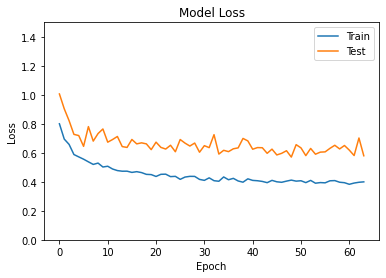

Epoch 1/1000
36/36 [==============================] - 13s 91ms/step - loss: 0.7811 - auc: 0.5296 - val_loss: 0.8122 - val_auc: 0.7915
Epoch 2/1000
36/36 [==============================] - 2s 60ms/step - loss: 0.6913 - auc: 0.5826 - val_loss: 0.8069 - val_auc: 0.7888
Epoch 3/1000
36/36 [==============================] - 2s 65ms/step - loss: 0.6280 - auc: 0.6494 - val_loss: 0.6597 - val_auc: 0.8117
Epoch 4/1000
36/36 [==============================] - 2s 62ms/step - loss: 0.5940 - auc: 0.6989 - val_loss: 0.6098 - val_auc: 0.8150
Epoch 5/1000
36/36 [==============================] - 2s 62ms/step - loss: 0.5701 - auc: 0.7314 - val_loss: 0.6170 - val_auc: 0.8066
Epoch 6/1000
36/36 [==============================] - 2s 64ms/step - loss: 0.5658 - auc: 0.7101 - val_loss: 0.6338 - val_auc: 0.8116
Epoch 7/1000
36/36 [==============================] - 2s 59ms/step - loss: 0.5467 - auc: 0.7550 - val_loss: 0.6016 - val_auc: 0.8080
Epoch 8/1000
36/36 [==============================] - 2s 64ms/step -

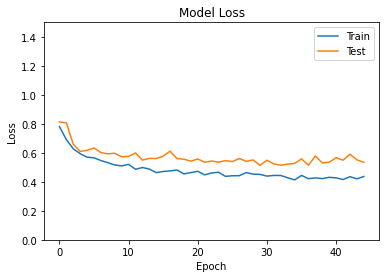

Epoch 1/1000
36/36 [==============================] - 12s 95ms/step - loss: 0.7569 - auc: 0.5101 - val_loss: 0.8099 - val_auc: 0.7949
Epoch 2/1000
36/36 [==============================] - 2s 60ms/step - loss: 0.6834 - auc: 0.5672 - val_loss: 0.7501 - val_auc: 0.8013
Epoch 3/1000
36/36 [==============================] - 2s 64ms/step - loss: 0.6387 - auc: 0.6408 - val_loss: 0.7020 - val_auc: 0.8079
Epoch 4/1000
36/36 [==============================] - 2s 63ms/step - loss: 0.6086 - auc: 0.6821 - val_loss: 0.6596 - val_auc: 0.8104
Epoch 5/1000
36/36 [==============================] - 2s 62ms/step - loss: 0.5797 - auc: 0.7137 - val_loss: 0.6435 - val_auc: 0.8081
Epoch 6/1000
36/36 [==============================] - 2s 64ms/step - loss: 0.5282 - auc: 0.7773 - val_loss: 0.7098 - val_auc: 0.7728
Epoch 7/1000
36/36 [==============================] - 2s 64ms/step - loss: 0.5510 - auc: 0.7474 - val_loss: 0.6372 - val_auc: 0.8016
Epoch 8/1000
36/36 [==============================] - 2s 65ms/step -

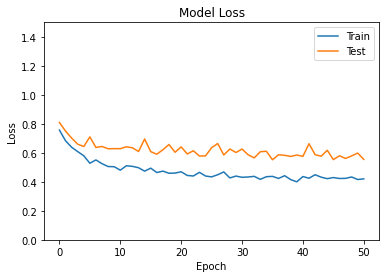

Epoch 1/1000
36/36 [==============================] - 12s 91ms/step - loss: 0.7339 - auc: 0.4884 - val_loss: 0.8839 - val_auc: 0.7263
Epoch 2/1000
36/36 [==============================] - 2s 60ms/step - loss: 0.6731 - auc: 0.5187 - val_loss: 0.8542 - val_auc: 0.6826
Epoch 3/1000
36/36 [==============================] - 2s 64ms/step - loss: 0.6524 - auc: 0.4954 - val_loss: 0.8147 - val_auc: 0.5703
Epoch 4/1000
36/36 [==============================] - 2s 63ms/step - loss: 0.6236 - auc: 0.5185 - val_loss: 0.7295 - val_auc: 0.8427
Epoch 5/1000
36/36 [==============================] - 2s 61ms/step - loss: 0.5464 - auc: 0.7155 - val_loss: 0.5642 - val_auc: 0.8565
Epoch 6/1000
36/36 [==============================] - 2s 65ms/step - loss: 0.5290 - auc: 0.7477 - val_loss: 0.6445 - val_auc: 0.8528
Epoch 7/1000
36/36 [==============================] - 2s 61ms/step - loss: 0.5537 - auc: 0.6656 - val_loss: 0.6931 - val_auc: 0.8513
Epoch 8/1000
36/36 [==============================] - 2s 64ms/step -

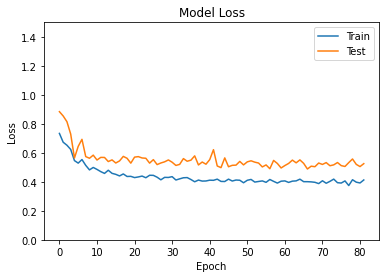

Mean acc:  0.8328912019729614
Confidence interval:  0.06142487799979779
All:  [0.9088541865348816, 0.8997395038604736, 0.8038194179534912, 0.7814428806304932, 0.7345678806304932, 0.8940972089767456, 0.8184210062026978, 0.8682330846786499, 0.856203019618988, 0.7635338306427002]


In [ ]:
# define hyperparameters
dropout_rate = 0.25#0.25 
learning_rate = 0.0020
recurrent_rate = 0.15 #0.15
l1_rate = 1e-4#-4
l2_rate = 1e-3#-4
preds_stat= np.array([])

n_split=10

skf = StratifiedKFold(n_splits=n_split, shuffle=False)
mean = 0
accuracy = []
i=1

for train_index, test_index in skf.split(df_all, y):#_mult):
    Xtrain = df_all[train_index]
    ytrain = y[train_index]
    Xtest = df_all[test_index]
    ytest = y[test_index]

    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

    model = Sequential()
    x= layers.BatchNormalization(axis=-1,
                                 momentum=0.99,
                                 epsilon=0.0001)(inputs)

    x = layers.Bidirectional(LSTM(10, 
                    activation ="sigmoid",
                    recurrent_activation = "sigmoid",
                    return_sequences=True, 
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2])))(x)
    
    x = layers.LSTM(20, 
                    activation ="tanh",
                    recurrent_activation = "softmax",
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    return_sequences=False)(x)

    x= layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)

    x = layers.Dense(20,activation = "relu",
                     kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate))(x)#softmax

    x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)
    x = layers.Dropout(dropout_rate) (x)

    x = layers.Dense(5, 
                     kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate), 
                     activation = "softmax")(x)
    
    x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)
    x = layers.Dropout(dropout_rate) (x)

    outputs = layers.Dense(1, activation = "sigmoid")(x)  

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )
    
    history = model.fit(Xtrain, ytrain, epochs=1000, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) #batch_size=75,monitor='val_loss'
   
    model.save("/content/gdrive/My Drive/Speciale/climodel"+str(i)+".h5")
    i+= 1 

    train_scores = model.evaluate(Xtrain, ytrain, verbose=2)
    test_scores = model.evaluate(Xtest, ytest, verbose=2)
    print("Train loss:", train_scores[0])
    print("Train accuracy:", train_scores[1])
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    accuracy.append(test_scores[1])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train","Test"],loc="best")
    plt.ylim([0,1.5])
    plt.show()

    preds_stat = np.concatenate([preds_stat,np.squeeze(model.predict(Xtest))])


print("Mean acc: ", np.mean(accuracy))
#create 95% confidence interval for population mean weight
print("Confidence interval: ", get_standard_diviation(accuracy) )
print("All: ", accuracy )

In [ ]:
#np.savetxt('LSTM_cli_3v.csv', preds_stat, delimiter=',')   
preds_stat.tofile("/content/gdrive/My Drive/Speciale/LSTM_cli_3v.csv")

#np.savetxt('y_lstm_cli_3v.csv', y, delimiter=',')   
#np.savetxt('LinR_cli_5v.csv', preds_stat, delimiter=',')  
#np.savetxt('y_cli_5v.csv', y_01356, delimiter=',') 
#np.savetxt('LinR_cli_5v_3v.csv', preds_stat, delimiter=',')  

In [ ]:
model.summary()

Model: "LSTM_clinical_data"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 3, 18)]           0         
                                                                 
 batch_normalization_10 (Bat  (None, 3, 18)            72        
 chNormalization)                                                
                                                                 
 bidirectional_9 (Bidirectio  (None, 3, 20)            2320      
 nal)                                                            
                                                                 
 lstm_21 (LSTM)              (None, 20)                3280      
                                                                 
 layer_normalization_27 (Lay  (None, 20)               40        
 erNormalization)                                                
                                                

In [ ]:
print("allo")

allo


In [ ]:
ean acc:  0.8057533502578735
Confidence interval:  0.04494522359899174
All:  [0.8048769235610962, 0.840501070022583, 0.767729640007019, 0.755782961845398, 0.8598761558532715]

### Validation 

In [ ]:
# define hyperparameters
dropout_rate = 0.25#0.25 
learning_rate = 0.0020
recurrent_rate = 0.15 #0.15
l1_rate = 1e-4#-4
l2_rate = 1e-3#-4

inputs = Input(shape=(df_all.shape[1], df_all.shape[2]))

model = Sequential()
x= layers.BatchNormalization(axis=-1,
                              momentum=0.99,
                              epsilon=0.0001)(inputs)

x = layers.Bidirectional(LSTM(10, 
                activation ="sigmoid",
                recurrent_activation = "sigmoid",
                return_sequences=True, 
                dropout=dropout_rate, 
                recurrent_dropout=recurrent_rate,
                kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                input_shape=(None, df_all.shape[1], df_all.shape[2])))(x)

x = layers.LSTM(20, 
                activation ="tanh",
                recurrent_activation = "softmax",
                dropout=dropout_rate, 
                recurrent_dropout=recurrent_rate,
                kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                return_sequences=False)(x)

x= layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)

x = layers.Dense(20,activation = "relu",
                  kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate))(x)#softmax

x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)
x = layers.Dropout(dropout_rate) (x)

x = layers.Dense(5, 
                  kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate), 
                  activation = "softmax")(x)

x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)
x = layers.Dropout(dropout_rate) (x)

outputs = layers.Dense(1, activation = "sigmoid")(x)  

model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

# define how to compile
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["AUC"], #,"Recall","accuracy"
    )

history = model.fit(df_all, y, epochs=1000, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) #batch_size=75,monitor='val_loss'

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="best")
plt.ylim([0,1.5])
plt.show()

In [ ]:
ypred = model.predict(df_all_val)
print("Accuracy Score: ", roc_auc_score(y_val.astype(float), ypred))

# Shallow LSTM

In [ ]:
# define hyperparameters
dropout_rate = 0.30 
learning_rate = 0.001 
recurrent_rate = 0.30
n_split=10
#Best : 0.7716447856617028, using {'hidden1': 35, 'l1_rate': 0.0001, 'l2_rate': 0.001, 'learning_rate': 0.001}
l1_rate = 0.0005
l2_rate = 0.005
mean = 0
accuracy = []
i=0 
preds_stat=np.array([])

for train_index, test_index in skf.split(df_all_mult, y_mult):
    Xtrain = df_all_mult[train_index]
    ytrain = y_mult[train_index]
    Xtest = df_all_mult[test_index]
    ytest = y_mult[test_index]
    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

    model = Sequential()
    x = layers.BatchNormalization(axis=-1,
                                 momentum=0.99,
                                 center =True,
                                 scale = True, 
                                 epsilon=0.0001)(inputs)

    x = layers.Bidirectional(LSTM(38,
                    activation ="sigmoid",
                    recurrent_activation = "sigmoid",
                    return_sequences=False,
                    kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2])))(x)

    outputs = layers.Dense(1, activation = "sigmoid")(x)  

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )
    
    history = model.fit(Xtrain, ytrain, epochs=1000, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) #batch_size=75,monitor='val_loss'

    model.save("/content/gdrive/My Drive/Speciale/climodel_shallow_morevisits"+str(i)+".h5")
    i+= 1 

    preds_stat = np.concatenate([preds_stat,np.squeeze(model.predict(Xtest))])

    train_scores = model.evaluate(Xtrain, ytrain, verbose=2)
    test_scores = model.evaluate(Xtest, ytest, verbose=2)
    print("Train loss:", train_scores[0])
    print("Train accuracy:", train_scores[1])
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    accuracy.append(test_scores[1])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylim([0,1.5])
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train","Test"],loc="best")
    plt.ylim([0,1])
    plt.show()

print("Mean acc: ", np.mean(accuracy))
#create 95% confidence interval for population mean weight
print("Confidence interval: ", get_standard_diviation(accuracy) )
print("All: ", accuracy )

In [ ]:
y_pred = model.predict(Xtrain).round()
confusion_matrix(ytrain, y_pred)

In [ ]:
#preds_stat.tofile("/content/gdrive/My Drive/Speciale/LSTM_shallow_cli_5v.csv")
#preds_stat.tofile("/content/gdrive/My Drive/Speciale/LSTM_shallow_cli_5v3v.csv")
#np.array(y_mult).tofile("/content/gdrive/My Drive/Speciale/y_lastm_cli_5v.csv")
#preds_stat.tofile("/content/gdrive/My Drive/Speciale/LSTM_shallow_cli_3v.csv")
#np.array(y_mult).tofile("/content/gdrive/My Drive/Speciale/y_lastm_cli_3v.csv")
#np.savetxt(fname='y_lastm_cli_5v.csv', x=y_mult, delimiter=',')   

### Validate

In [ ]:
# define hyperparameters
dropout_rate = 0.30 
learning_rate = 0.001 
recurrent_rate = 0.30
l1_rate = 0.0005
l2_rate = 0.005

inputs = Input(shape=(df_all_mult.shape[1], df_all_mult.shape[2]))

model = Sequential()
x = layers.BatchNormalization(axis=-1,
                              momentum=0.99,
                              center =True,
                              scale = True, 
                              epsilon=0.0001)(inputs)

x = layers.Bidirectional(LSTM(38,
                activation ="sigmoid",
                recurrent_activation = "sigmoid",
                return_sequences=False,
                kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                dropout=dropout_rate, 
                recurrent_dropout=recurrent_rate,
                input_shape=(None, df_all_mult.shape[1], df_all_mult.shape[2])))(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)  

model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

# define how to compile
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["AUC"], #,"Recall","accuracy"
    )

history = model.fit(df_all_mult, y_mult, epochs=1000, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) #batch_size=75,monitor='val_loss'

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylim([0,1.5])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="best")
plt.ylim([0,1])
plt.show()


In [ ]:
ypred = model.predict(df_all_mult_val)
print("Accuracy Score: ", roc_auc_score(y_mult_val.astype(float), ypred))

 # Gidseatch LR + Dropout

In [ ]:
def create_model(learning_rate,dropout_rate,recurrent_rate,kr, kr2):
    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

    model = Sequential()
    x= layers.BatchNormalization(axis=-1,
                                 momentum=0.99,
                                 epsilon=0.0001)(inputs)

    x = layers.Bidirectional(LSTM(10, 
                    activation ="sigmoid",
                    recurrent_activation = "sigmoid",
                    return_sequences=True, 
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    kernel_regularizer=regularizers.L2(kr2),
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2])))(x)
    
    x = layers.LSTM(20, 
                    activation ="tanh",
                    recurrent_activation = "softmax",
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    kernel_regularizer=regularizers.L2(kr2),
                    return_sequences=False)(x)

    x = layers.Dense(20,activation = "relu",
                     kernel_regularizer=regularizers.L1(kr))(x)#softmax
    x = layers.Dropout(dropout_rate) (x)

    x = layers.Dense(5, 
                     kernel_regularizer=regularizers.L1(kr), 
                     activation = "softmax")(x)
    x = layers.Dropout(dropout_rate) (x)

    outputs = layers.Dense(1, activation = "sigmoid")(x)  

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )

    return model

model = KerasClassifier(build_fn = create_model,verbose = 1, validation_split=0.20,callbacks=EarlyStopping(monitor='val_loss', patience=20))

In [ ]:


# Define the grid search parameters
n_split = 3
learning_rate = [0.001,0.0001]
dropout_rate = [0.15, 0.25]
recurrent_rate = [ 0.15]
kr2 =[0.00001, 0.000005, 0.000001]
kr =[0.0005, 0.0001]

# Make a dictionary of the grid search parametersparam_grid = dict(batch_size = batch_size,epochs = epochs)
param_grids = dict(learning_rate = learning_rate,dropout_rate = dropout_rate, recurrent_rate=recurrent_rate,kr=kr, kr2=kr2)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = StratifiedKFold(n_splits=n_split,random_state=True, shuffle=True),verbose = 1,scoring="roc_auc")
grid_result = grid.fit(df_all, y,callbacks=EarlyStopping(monitor='val_loss', patience=25),batch_size = 25, epochs= 1000)

### Split into training and test set

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df_all,y, test_size=0.20, random_state=42, shuffle=True)

In [ ]:
# normalize data
# retrice mean and std
mean = np.zeros(Xtrain.shape[2])
std = np.zeros(Xtrain.shape[2])

for i in range(Xtrain.shape[1]):
  mean += np.mean(Xtrain[:,i,:],axis=0)
  std += np.std(Xtrain[:,i,:],axis=0)

def normalize(data,m,s):  
  m = m/data.shape[1]
  s = s/data.shape[1]

  for i in range(data.shape[1]):
    data[:,i,:] = (data[:,i,:]-m)/std
  
  return data

Xtrain = normalize(Xtrain,mean,std)
Xtest = normalize(Xtest,mean,std)

In [ ]:
y_pred = model.predict(Xtrain).round()
confusion_matrix(ytrain, y_pred)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="best")
plt.show()

In [ ]:
#Plot as a graph
#keras.utils.plot_model(model, "LSTM_clinical_data.png")
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:
# save model
model.save("LSTM_clinical_data")

# Back to basics 5-Fold *CV* 

In [ ]:
dropout_rate = 0.30 #from grid
learning_rate = 0.0001 #from grid
recurrent_rate = 0.30
kr1 = 0.0005
kr2 = 0.05

n_split = 10

skf = StratifiedKFold(n_splits=n_split,random_state=42, shuffle=True)
mean = 0
accuracy = []


for train_index, test_index in skf.split(df_all, y):
    Xtrain = df_all[train_index]
    ytrain = y[train_index]
    Xtest = df_all[test_index]
    ytest = y[test_index]

    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

    model = Sequential()
    x= layers.BatchNormalization(axis=-1,
                                 momentum=0.99,
                                 epsilon=0.0001)(inputs)

    x = layers.LSTM(Xtrain.shape[2], #59 
                  activation ="sigmoid",
                  recurrent_activation = "sigmoid",
                  recurrent_dropout =  recurrent_rate,
                  bias_regularizer=regularizers.L2(kr2),
                  recurrent_regularizer=regularizers.L2( kr2),
                  kernel_regularizer=regularizers.L2( l2=kr2),
                  return_sequences=False, 
                  input_shape=(None, Xtrain.shape[1], Xtrain.shape[2]))(x)

    x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)
    x = layers.Dropout(dropout_rate) (x)
    
    #x = layers.Dense(5,
     #             bias_regularizer=regularizers.L2(kr2),
      #            kernel_regularizer=regularizers.L2( l2=kr2))(x)

    outputs = layers.Dense(1, activation = "sigmoid")(x)  

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),#BinaryCrossentropy(),
#        loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )
    
    history = model.fit(Xtrain, ytrain, epochs=1000, validation_split=0.15, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=20), batch_size=35) #batch_size=75,monitor='val_loss'

    train_scores = model.evaluate(Xtrain, ytrain, verbose=2)
    test_scores = model.evaluate(Xtest, ytest, verbose=2)
  
    print("Train loss:", train_scores[0])
    print("Train accuracy:", train_scores[1])
    print("Test loss:", test_scores[0])

    ypred = model.predict(Xtest)
    print("Accuracy Score: ", roc_auc_score(ytest.astype(float), ypred))
    print("Test accuracy:", test_scores[1])
    accuracy.append(test_scores[1])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train","Test"],loc="best")
    plt.ylim([0,2])
    plt.show()

print("Mean acc: ", np.mean(accuracy))
#create 95% confidence interval for population mean weight
print("Confidence interval: ", get_standard_diviation(accuracy) )
print("All: ", accuracy )

In [ ]:
#Mean acc:  0.8337960441907247 Confidence interval:  0.01624283381880808 All:  [0.8412328362464905, 0.8151662349700928, 0.8449890613555908] # 2 dense nothing else
#Mean acc:  0.8344757258892059 Confidence interval:  0.035537448842402196 # LSTM added All:  [0.820870578289032, 0.81547611951828, 0.858796238899231, 0.8447145223617554, 0.8217592835426331, 0.83314049243927, 0.7830827236175537, 0.7996240854263306, 0.8584586381912231, 0.9088345766067505]
#Mean acc:  0.8353470623493194 Confidence interval:  0.0348902731716404
#Mean acc:  0.8430311262607575  Confidence interval:  0.03647084784177799
#Mean acc:  0.8449315249919891 Confidence interval:  0.03488350092279596
#Mean acc:  0.8402410319873265 Confidence interval:  0.03220505914231502

In [ ]:
np.squeeze(model.predict(Xtest)).shape, ytest.astype(float).shape

In [ ]:
    x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)


In [ ]:
train_scores

# Save for ensamble

In [ ]:
# define hyperparameters
dropout_rate = 0.25#0.25 
learning_rate = 0.0020
recurrent_rate = 0.15 #0.15
l1_rate = 1e-4#-4
l2_rate = 1e-3#-4

inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

model = Sequential()
x= layers.BatchNormalization(axis=-1,
                              momentum=0.99,
                              epsilon=0.0001)(inputs)

x = layers.Bidirectional(LSTM(10, 
                activation ="sigmoid",
                recurrent_activation = "sigmoid",
                return_sequences=True, 
                dropout=dropout_rate, 
                recurrent_dropout=recurrent_rate,
                kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                input_shape=(None, Xtrain.shape[1], Xtrain.shape[2])))(x)

x = layers.LSTM(20, 
                activation ="tanh",
                recurrent_activation = "softmax",
                dropout=dropout_rate, 
                recurrent_dropout=recurrent_rate,
                kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                return_sequences=False)(x)

x= layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)

x = layers.Dense(20,activation = "relu",
                  kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate))(x)#softmax

x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)
x = layers.Dropout(dropout_rate) (x)

x = layers.Dense(5, 
                  kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate), 
                  activation = "softmax")(x)

x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)
x = layers.Dropout(dropout_rate) (x)

outputs = layers.Dense(1, activation = "sigmoid")(x)  

model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")
model.save("/content/gdrive/My Drive/Speciale/climodel.h5")